In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [3]:
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
IMAGE_SIZE = 224 
BATCH_SIZE = 16

# Loading the Dataset

In [5]:
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/ML Implementation/Corn-disease/corn_disease_dataset/data",
     shuffle = True,
     seed=SEED,
     image_size = (IMAGE_SIZE, IMAGE_SIZE),
     batch_size = BATCH_SIZE
)

Found 4814 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [7]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(16, 224, 224, 3)
[3 2 0 2 1 1 3 3 3 2 3 3 0 1 2 0]


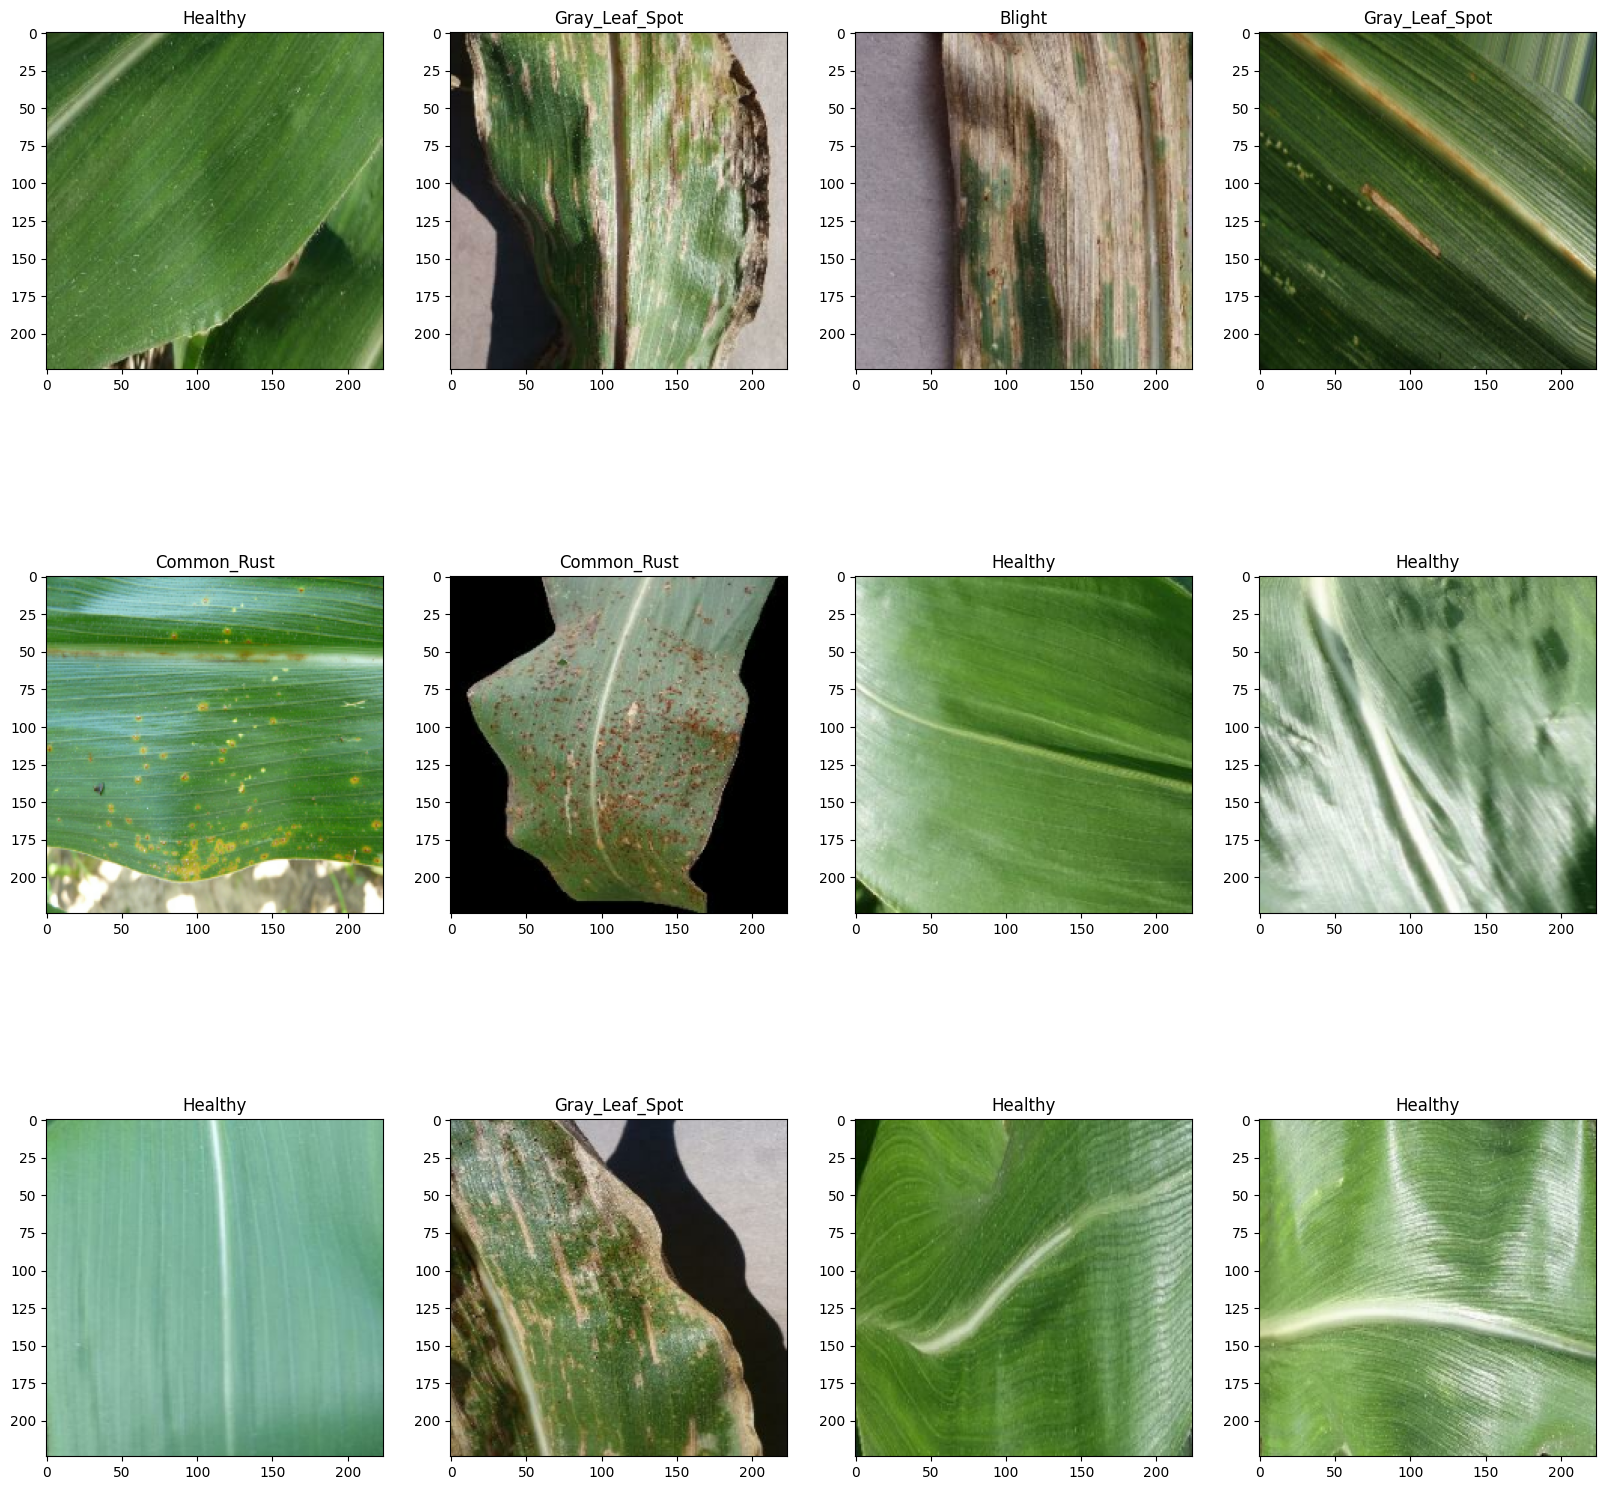

In [8]:
plt.figure(figsize = (20,20)) # Lets increse plot size of our plots
#Lets explore our batch and display some images
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
    #To visualize all images plot as subplot 
        ax = plt.subplot(3,4,i+1)
    #Visualize image using matplotlib imshow function plt.imshow expects a 3D numpy array
        plt.title(class_names[label_batch[i]]) # Displaying its class label as title
        plt.imshow(image_batch[i].numpy().astype('uint8'))
    print(image_batch.shape)
    print(label_batch.numpy())

In [9]:
y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))#np.bincount(array) counts occurence of each element in array.

[1146 1306 1200 1162]


# Data Partition

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Count dataset size
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

240

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Rescaling & Augmentation

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])


In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [16]:
# Apply resize & rescale to all datasets
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [17]:
# Apply augmentation only to training
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=AUTOTUNE)

# Loading the Model : ResNet50

In [18]:
# Create the base model from the pre-trained model ResNet50
base_model = tf.keras.applications.resnet50.ResNet50(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()
print("Number of layers in ResNet50 are: ", len(base_model.layers))
layer_names = [layer.name for layer in base_model.layers]
print(layer_names)
print(len(layer_names))

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [29]:
base_model.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])


In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


In [31]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10
240/240 [==============================] - 188s 775ms/step - loss: 0.7492 - accuracy: 0.7238 - val_loss: 0.4412 - val_accuracy: 0.8292
Epoch 2/10
240/240 [==============================] - 182s 759ms/step - loss: 0.4754 - accuracy: 0.8181 - val_loss: 0.3493 - val_accuracy: 0.8583
Epoch 3/10
240/240 [==============================] - 181s 754ms/step - loss: 0.4182 - accuracy: 0.8330 - val_loss: 0.3324 - val_accuracy: 0.8729
Epoch 4/10
240/240 [==============================] - 181s 756ms/step - loss: 0.3873 - accuracy: 0.8520 - val_loss: 0.3446 - val_accuracy: 0.8667
Epoch 5/10
240/240 [==============================] - 181s 752ms/step - loss: 0.3778 - accuracy: 0.8570 - val_loss: 0.3538 - val_accuracy: 0.8562
Epoch 6/10
240/240 [==============================] - 180s 752ms/step - loss: 0.3587 - accuracy: 0.8671 - val_loss: 0.2828 - val_accuracy: 0.8771
Epoch 7/10
240/240 [==============================] - 182s 760ms/step - loss: 0.3569 - accuracy: 0.8671 - val_loss: 0.3538 -

In [32]:
# Unfreeze base model
base_model.trainable = True

# Freeze earlier layers except BN
j=1
for layer in base_model.layers[0:176]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True
        print(f"BN layer{j} unfreezed.")
        j+=1

BN layer1 unfreezed.
BN layer2 unfreezed.
BN layer3 unfreezed.
BN layer4 unfreezed.
BN layer5 unfreezed.
BN layer6 unfreezed.
BN layer7 unfreezed.
BN layer8 unfreezed.
BN layer9 unfreezed.
BN layer10 unfreezed.
BN layer11 unfreezed.
BN layer12 unfreezed.
BN layer13 unfreezed.
BN layer14 unfreezed.
BN layer15 unfreezed.
BN layer16 unfreezed.
BN layer17 unfreezed.
BN layer18 unfreezed.
BN layer19 unfreezed.
BN layer20 unfreezed.
BN layer21 unfreezed.
BN layer22 unfreezed.
BN layer23 unfreezed.
BN layer24 unfreezed.
BN layer25 unfreezed.
BN layer26 unfreezed.
BN layer27 unfreezed.
BN layer28 unfreezed.
BN layer29 unfreezed.
BN layer30 unfreezed.
BN layer31 unfreezed.
BN layer32 unfreezed.
BN layer33 unfreezed.
BN layer34 unfreezed.
BN layer35 unfreezed.
BN layer36 unfreezed.
BN layer37 unfreezed.
BN layer38 unfreezed.
BN layer39 unfreezed.
BN layer40 unfreezed.
BN layer41 unfreezed.
BN layer42 unfreezed.
BN layer43 unfreezed.
BN layer44 unfreezed.
BN layer45 unfreezed.
BN layer46 unfreeze

In [33]:
# Compile again with lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [37]:
fine_tune_epochs = 20
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,                    # total epochs (e.g., 30)
    initial_epoch=history.epoch[-1]+1,      # start from next epoch
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 11/30
240/240 [==============================] - 552s 2s/step - loss: 1.2553 - accuracy: 0.5417 - val_loss: 0.6840 - val_accuracy: 0.7375
Epoch 12/30
240/240 [==============================] - 548s 2s/step - loss: 0.9208 - accuracy: 0.6430 - val_loss: 0.5758 - val_accuracy: 0.7458
Epoch 13/30
240/240 [==============================] - 551s 2s/step - loss: 0.7944 - accuracy: 0.6993 - val_loss: 0.5201 - val_accuracy: 0.7833
Epoch 14/30
240/240 [==============================] - 557s 2s/step - loss: 0.6673 - accuracy: 0.7423 - val_loss: 0.4385 - val_accuracy: 0.8104
Epoch 15/30
240/240 [==============================] - 551s 2s/step - loss: 0.6037 - accuracy: 0.7710 - val_loss: 0.3906 - val_accuracy: 0.8375
Epoch 16/30
240/240 [==============================] - 552s 2s/step - loss: 0.5407 - accuracy: 0.7923 - val_loss: 0.3533 - val_accuracy: 0.8542
Epoch 17/30
240/240 [==============================] - 552s 2s/step - loss: 0.5167 - accuracy: 0.7960 - val_loss: 0.3215 - val_accuracy:

In [38]:
model.save('Corn_ResNet50_finetuned.keras')

In [39]:
acc = history.history['accuracy'] +history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] +  history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] +  history_fine.history['val_loss']

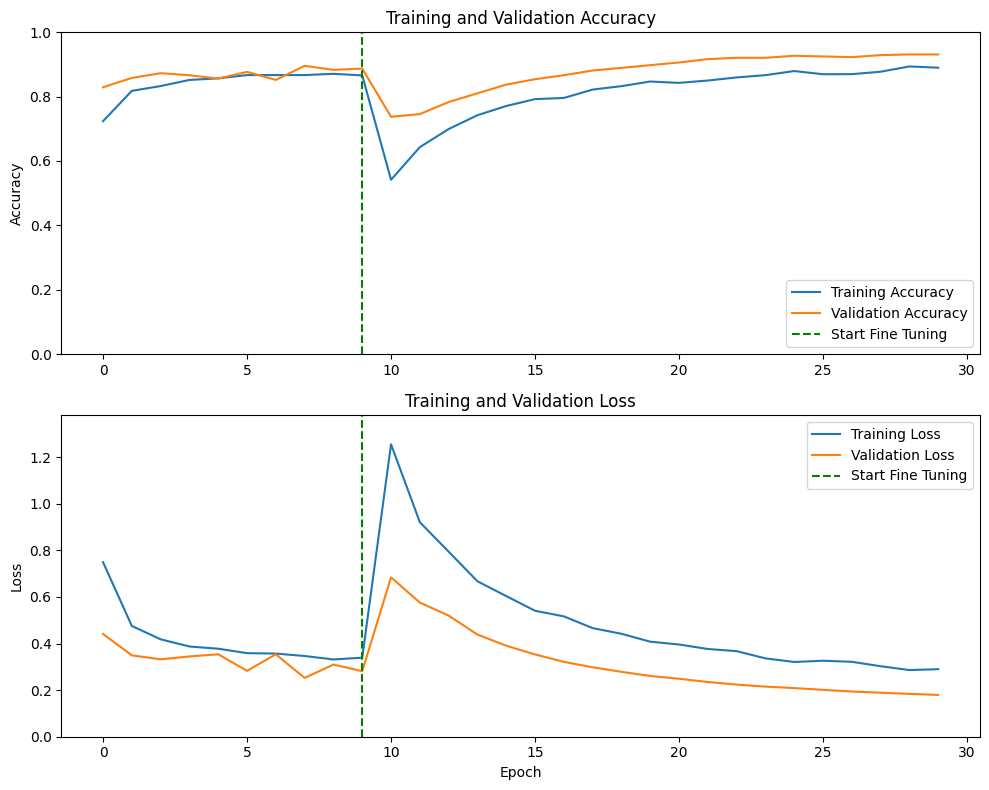

In [42]:
import matplotlib.pyplot as plt

# Total epochs and fine-tune start epoch
initial_epochs = 10
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

plt.figure(figsize=(10, 8))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='tab:blue')
plt.plot(val_acc, label='Validation Accuracy', color='tab:orange')
plt.axvline(x=initial_epochs-1, color='green', linestyle='--', label='Start Fine Tuning')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='tab:blue')
plt.plot(val_loss, label='Validation Loss', color='tab:orange')
plt.axvline(x=initial_epochs-1, color='green', linestyle='--', label='Start Fine Tuning')
plt.ylim([0, max(max(loss), max(val_loss)) * 1.1])  # dynamic upper limit
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


first image to print


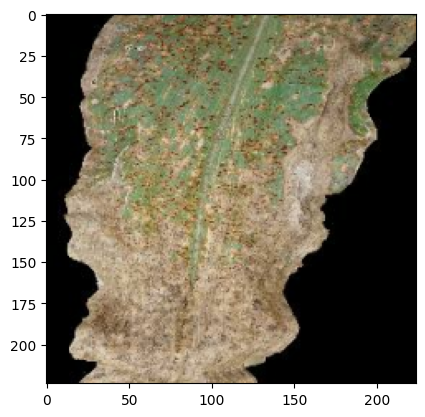

first image actual label: Common_Rust
1/1 [==============================] - 2s 2s/step
predicted label: Common_Rust


In [43]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to print")
    plt.imshow(first_image)
    plt.show()

    print("first image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 114ms/step


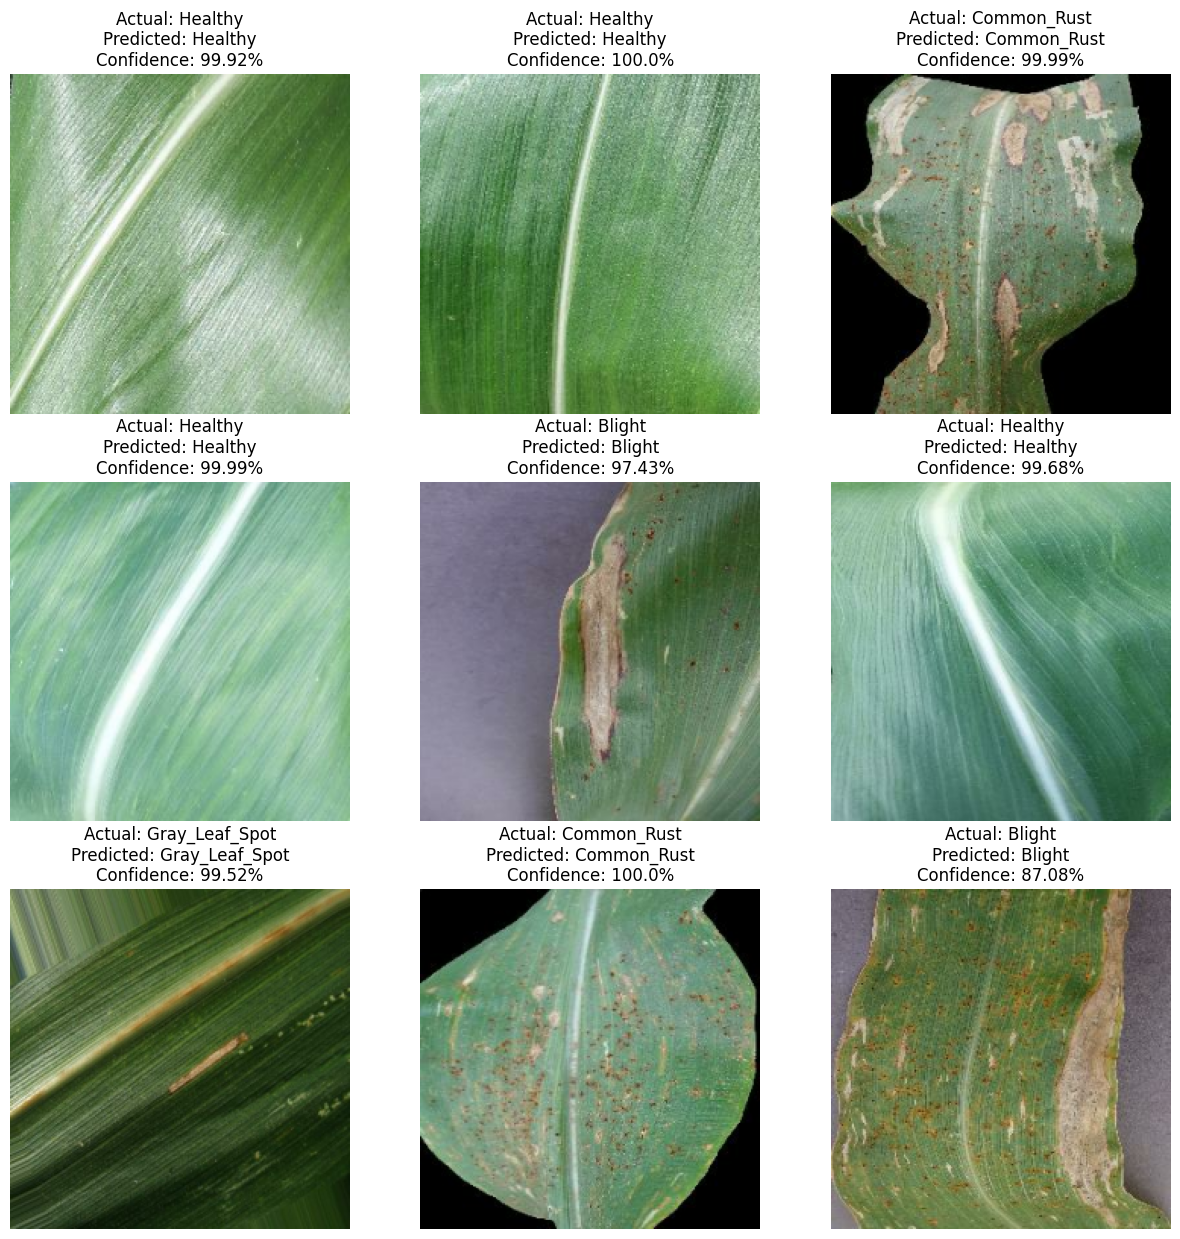

In [45]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")


# Model Predictions

In [46]:
import numpy as np

y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()             # shape (batch_size,)
    

    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)
    
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)  

1/1 [==============================] - 1s 592ms/step


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Accuracy

In [48]:
acc = accuracy_score(y_true, y_pred)

In [49]:
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 93.12%


# Precision

In [50]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'

In [51]:
print(f"Precision: {precision * 100:.2f}%")

Precision: 93.37%


# Recall

In [52]:
recall = recall_score(y_true, y_pred, average='weighted')

In [53]:
print(f"Recall: {recall * 100:.2f}%")

Recall: 93.12%


# F1-Score

In [54]:
f1 = f1_score(y_true, y_pred, average='weighted')

In [55]:
print(f"f1: {f1 * 100:.2f}%")

f1: 93.19%


# Confusion Matrix

In [56]:
cm = confusion_matrix(y_true, y_pred)

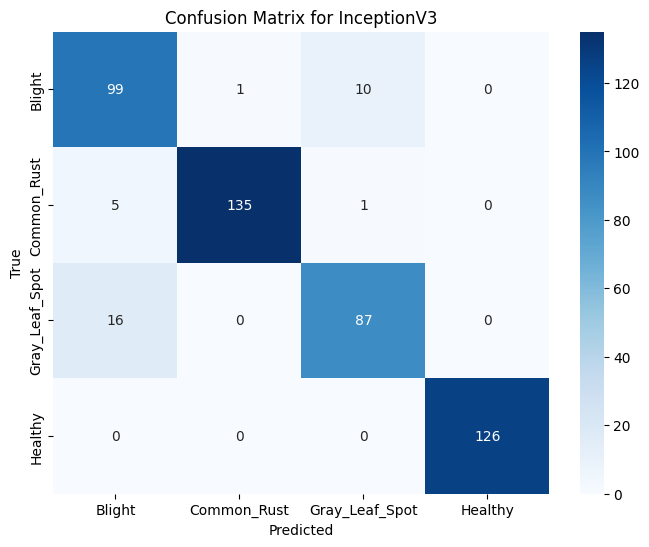

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for InceptionV3')
plt.show()


# AUROC

In [58]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)


Macro-Averaged ROC-AUC Score: 99.18%


In [59]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\ML Implementation\Corn-disease


In [60]:
model_version= "ResNet50_final_224"
model.save(f"./models/{model_version}.keras")